In [192]:
import numpy as np

In [193]:
import csv

In [194]:
FILE_DIR = '../../Developer/Data/prices/NYSE/'

In [195]:
import glob
import os.path
from os import path
from datetime import datetime

In [196]:
FILE_TYPE = '.csv'

In [326]:
class Source:
    def __init__(self, directory, file_type='.csv'):
        self.directory = directory
        self.file_type = file_type

        self.glob_string = f'{self.directory}*{self.file_type}'
        self.data = {}

    @property
    def instrument_filenames(self):
        return glob.glob(self.glob_string)

    @property
    def instrument_names(self):
        return [i[len(self.directory):-len(self.file_type)] for i in self.instrument_filenames]

    def format_row(self, *args):
        raise NotImplementedError
        
    def load_source(self, location):
        raise NotImplementedError

    def __getitem__(self, key):
        # Check the cache
        item = self.data.get(key)
        if item is not None:
            return item
        
        # Optimistically open the file. If it isn't there, the error is informative.
        filename = f'{self.directory}{key}{self.file_type}'
        
        item = self.load_source(filename)
        self.data[key] = item

        return item


class EODDataSource(Source):
    def __init__(self, *args, **kwargs):
        self.datetime_format = '%d-%b-%Y'
        column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        
        self.feature_names = []
        
        self.features = None
        
        super().__init__(*args, **kwargs)
        
    def load_source(self, location):
        with open(location) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        return items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.feature_names.append(name)
        # add feature to features?
        if features is None:
            self.features = features
        else:
            self.features = np.vstack((self.features, features))
        
    def __getattr__(self, item):
        try:
            # return the attribute if it exists on the instance
            return self.__getattribute__(item)
        except AttributeError as e:
            try:
                column_idx = self.column_names.index(item)
                return self.features[:,column_idx]
            except ValueError:
                pass
            
            try:
                feature_idx = self.feature_names.index(item)
                return self.features[:,feature_idx]
            except ValueError:
                raise AttributeError
                

SyntaxError: unexpected EOF while parsing (<ipython-input-326-1e2183b54f50>, line 85)

In [198]:
s = EODDataSource('../../Developer/Data/prices/NYSE/')

In [199]:
s['LUV'].shape

(4963, 9)

In [200]:
import talib as ta

In [201]:
ta.EMA(s['LUV'][:,-3]).shape

(4963,)

In [202]:
s['LUV'].shape

(4963, 9)

In [203]:
s['LUV'][1]

array([ 4.00000e+00,  1.00000e+00,  2.00000e+03,  1.05800e+01,
        1.07500e+01,  1.02900e+01,  1.02900e+01,  4.70205e+06,
       -4.00000e-02])

In [204]:
# day, month, year, open, high, low, close, volume, t+1 returns
import matplotlib.pyplot as plt

In [205]:
idx = np.where((s['LUV'][:,0] == 23) & (s['LUV'][:,1] == 5))[0]

In [206]:
rets = np.stack([np.cumsum(s['LUV'][:,-1][i:i+25]) for i in idx])

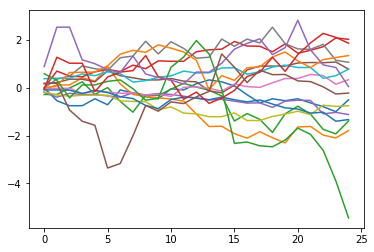

In [207]:
plt.plot(rets.T)

In [255]:
returns = np.stack([s['LUV'][:,-1][i:i+100] for i in idx])

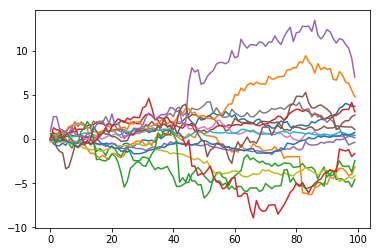

In [256]:
plt.plot(np.cumsum(returns, axis=1).T)

In [257]:
total_returns = np.cumsum(returns, axis=1)

In [260]:
# Run a random choice of 1000 returns across the total returns, iterating through each index
# AKA: If you held for 1 timestep vs 2 timesteps, how would those monte carlo graphs differ?
mcs = np.stack([np.cumsum(np.random.choice(total_returns[:,i], 1000)) for i in range(100)])

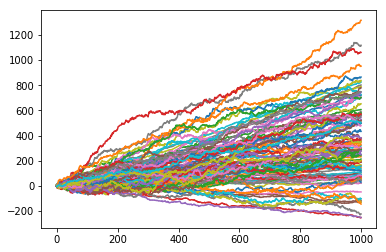

In [261]:
plt.plot(mcs.T)

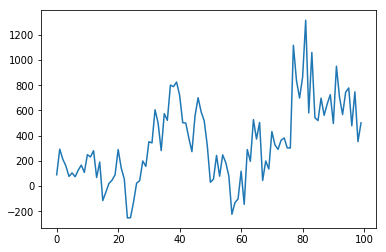

In [262]:
plt.plot(mcs[:,-1])

In [263]:
# inputs:
# asset (numpy array)
# strategy (boolean?)
# -> indexes

# strategy = list of indexes
# strategy validation = time analysis of X periods out, monte carlo

In [278]:
idx = np.where(s['LUV'][:,-3] > ta.EMA(s['LUV'][:,-1]))[0]

In [279]:
returns = np.stack([s['LUV'][:,-1][i:i+100] for i in idx[:-100]])

In [280]:
total_returns = np.cumsum(returns, axis=1)

In [281]:
mcs = np.stack([np.cumsum(np.random.choice(total_returns[:,i], 1000)) for i in range(100)])

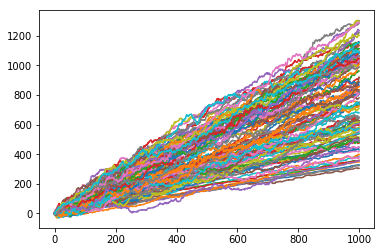

In [282]:
plt.plot(mcs.T)

In [283]:
def run_monte(asset, idx):
    returns = np.stack([asset[:,-1][i:i+100] for i in idx])
    total_returns = np.cumsum(returns, axis=1)
    mcs = np.stack([np.cumsum(np.random.choice(total_returns[:,i], 1000)) for i in range(100)])
    return mcs

In [285]:
idx = np.where(s['LUV'][:,-1] > ta.EMA(s['LUV'][:,-1], timeperiod=30))[0]

In [287]:
mcs = run_monte(s['LUV'], idx[:-100])

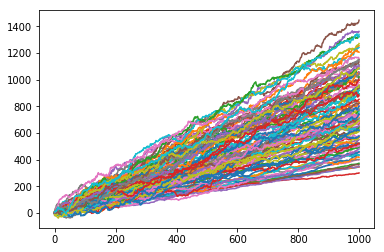

In [288]:
plt.plot(mcs.T)

In [297]:
def run_monte_single(asset, idx, samples=1000, simulations=1000):
    returns = asset[:,-1][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [318]:
# get indexes where the closing price is above the ema
idx = np.where(s['LUV'][:,-3] > ta.EMA(s['LUV'][:,-3], timeperiod=30))[0]

In [319]:
idx[:10]

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [320]:
s['LUV'][:,-1][idx]

array([ 0.16, -0.12,  0.  , ...,  0.  , -0.11, -0.92])

In [321]:
mcs = run_monte_single(s['LUV'], idx)

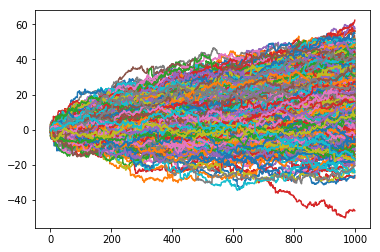

In [322]:
plt.plot(mcs.T)

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   9.,   5.,  14.,  22.,
         15.,  34.,  58., 100., 236., 377., 733., 460., 266., 129.,  82.,
         59.,  26.,  22.,  20.,   6.,   2.,   3.,   3.,   4.,   0.,   1.,
          1.,   2.,   0.,   2.,   0.,   1.]),
 array([-4.71  , -4.5454, -4.3808, -4.2162, -4.0516, -3.887 , -3.7224,
        -3.5578, -3.3932, -3.2286, -3.064 , -2.8994, -2.7348, -2.5702,
        -2.4056, -2.241 , -2.0764, -1.9118, -1.7472, -1.5826, -1.418 ,
        -1.2534, -1.0888, -0.9242, -0.7596, -0.595 , -0.4304, -0.2658,
        -0.1012,  0.0634,  0.228 ,  0.3926,  0.5572,  0.7218,  0.8864,
         1.051 ,  1.2156,  1.3802,  1.5448,  1.7094,  1.874 ,  2.0386,
         2.2032,  2.3678,  2.5324,  2.697 ,  2.8616,  3.0262,  3.1908,
         3.3554,  3.52  ]),
 <a list of 50 Patch objects>)

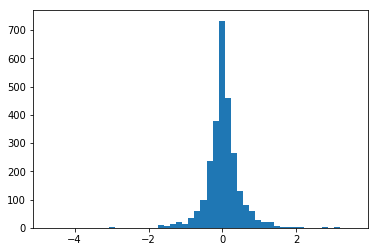

In [324]:
plt.hist(s['LUV'][:,-1][idx], bins=50)